### Author: Dr. Claudio S. Quiroga-Lombard 

### Exercise’s description

In [1]:
"""
Description:  There are two sides in a ride-hailing marketplace: riders (demand) and drivers (supply). 
One of the challenges that we aim to solve is efficient supply allocation, 
so riders can always get a ride and drivers have stable earnings. 
Knowledge about how demand changes over time and space is crucial to comprehend supply dynamics. 

Tasks: 

-Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at 
given time and location
-Build and document a baseline model for your solution
-Describe how you would design and deploy such a model
-Describe how to communicate model recommendations to drivers
-Think through and describe the design of the experiment  that would validate your solution for 
live operations taking into account marketplace specifics

Data Description:

The source data is approximately 630000 rows of synthetic ride demand data:

start_time - time when the order was made
start_lat - latitude of the order's pick-up point
start_lng - longitude of the order's pick-up point
end_lat - latitude of the order's destination point
end_lng - longitude of the order's destination point
ride_value - how much monetary value is in this particular ride
"""

"\nDescription:  There are two sides in a ride-hailing marketplace: riders (demand) and drivers (supply). \nOne of the challenges that we aim to solve is efficient supply allocation, \nso riders can always get a ride and drivers have stable earnings. \nKnowledge about how demand changes over time and space is crucial to comprehend supply dynamics. \n\nTasks: \n\n-Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at \ngiven time and location\n-Build and document a baseline model for your solution\n-Describe how you would design and deploy such a model\n-Describe how to communicate model recommendations to drivers\n-Think through and describe the design of the experiment  that would validate your solution for \nlive operations taking into account marketplace specifics\n\nData Description:\n\nThe source data is approximately 630000 rows of synthetic ride demand data:\n\nstart_time - time when the order was made\nstart_lat - latitude of 

### Get Data

In [1]:
import pandas as pd
import numpy as np

PATH = 'C:\\Users\\celes\\3D Objects\\Data\\Data_for_Tasks\\'

chunks = []
chunks = pd.read_csv(PATH + '\\robotex5.csv') #, chunksize = 100000) 

# chunksize= is a very useful argument because the output of read_csv will be an iterator, 
# so you can call the next() function on it to get the specific chunk you want without straining your memory. 
# ref.: https://stackoverflow.com/questions/23853553/python-pandas-how-to-read-only-first-n-rows-of-csv-files-in

# After analyzing the data, I realized that it was not necessary to partition the data as 
# it fits within the memory of my computer.

df = []
#df = next(chunks) ### get a specific chunk of data, if chunksize argument is used.
df = chunks.copy()

df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S')

print("df dimensions:", df.shape)

df.head()

df dimensions: (627210, 6)


,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


In [ ]:
""" I create a segmented 3D space consisting of latitude, longitude, and time bins to quantify 
the number of rides at specific locations and times. 
This particular methodology (a greatly simplified version of the "real" challenge) aims 
to direct drivers to areas anticipated to have increased demand, 
and thus represents just one aspect of the broader supply and demand scenario (for example, competition 
between drivers, unfulfilled demand etc).

The entire geographical map will be divided into 3 x 3 bins. This covers the area, the other bins cover the time."""

### Latitude & Longitude Bins


In [2]:
### Get min, max latitudes and longitudes

min_lat = df.start_lat.min()
max_lat = df.start_lat.max()

min_lng = df.start_lng.min()
max_lng = df.start_lng.max()

print(min_lat, max_lat, min_lng, max_lng)

int_lat = 0.08
int_lng = 0.15

bin_lat = np.arange(min_lat, max_lat, int_lat).tolist()
bin_lng = np.arange(min_lng, max_lng, int_lng).tolist()

bin_lat, bin_lng

59.32155738688771 59.56699804588873 24.505199098293403 24.973743413626107


([59.32155738688771, 59.40155738688771, 59.48155738688771, 59.561557386887706],
 [24.505199098293403, 24.6551990982934, 24.8051990982934, 24.9551990982934])

### Time Bins

In [3]:
### Data sampled from 2020-03-1 to 2022-03-28
start_time = df.start_time.min() 
end_time = df.start_time.max()

print(start_time, end_time)

2022-03-01 00:00:07.936317 2022-03-28 23:59:53.175658


In [4]:
""" The time bin is selected to be of 1 hour. """ 

time_bins = []
time_bins = pd.date_range(start_time,end_time,freq='60 min')
print(time_bins[0], time_bins[-1], len(time_bins))

2022-03-01 00:00:07.936317 2022-03-28 23:00:07.936317 672


### Plot the whole data with the geo bins

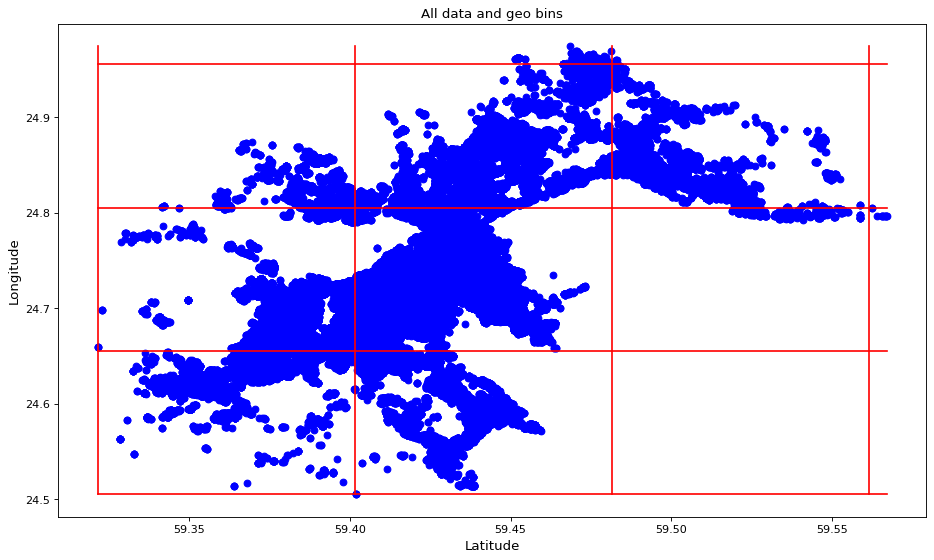

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 8), dpi=80)

x = df.start_lat.values
y = df.start_lng.values

for BIN in bin_lat:
    plt.plot([BIN, BIN], [min(y), max(y)], c='r')
for BIN in bin_lng:
    plt.plot([min(x), max(x)], [BIN, BIN], c='r')
    
plt.scatter(x, y, c='b')

plt.title('All data and geo bins', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.show()

### Create Time Series

#### For each time bin, count the number of rides that fall into a geo-bin.

In [6]:
time_series = [] ### time_series to forecast.

for z in range(0, len(time_bins)-1):
        
    df_time_section = []
    df_time_section = df[(df.start_time >= time_bins[z]) & (df.start_time < time_bins[z+1])]
    
    #"""
    
    for i in range(0,len(bin_lat)-1):
        for j in range(0,len(bin_lng)-1):
        
            df_time_lat_long_section = []
            df_time_lat_long_section = df_time_section[(df_time_section.start_lat >= bin_lat[i]) &
                                                      (df_time_section.start_lat < bin_lat[i+1]) &
                                                      (df_time_section.start_lng >= bin_lng[j]) &
                                                      (df_time_section.start_lng < bin_lng[j+1])]
            
            
            ### Create time series

            time = []
            time = (time_bins[z+1] - time_bins[z])/2 + time_bins[z] 

            latitude = []
            latitude = int_lat/2 + bin_lat[i]

            longitude = []
            longitude = int_lng/2 + bin_lng[j]

            number_of_rides = []
            number_of_rides = len(df_time_lat_long_section)

            time_series.append([time, number_of_rides, latitude, longitude])
    
    
    
time_series = pd.DataFrame(time_series, columns=['time', 'number_of_rides', 'latitude', 'longitude'])

time_series.head()

,time,number_of_rides,latitude,longitude
0,2022-03-01 00:30:07.936317,12,59.361557,24.580199
1,2022-03-01 00:30:07.936317,33,59.361557,24.730199
2,2022-03-01 00:30:07.936317,1,59.361557,24.880199
3,2022-03-01 00:30:07.936317,27,59.441557,24.580199
4,2022-03-01 00:30:07.936317,474,59.441557,24.730199


In [7]:
latitude_list = time_series.latitude.unique()
longitude_list = time_series.longitude.unique()

latitude_list, longitude_list

(array([59.36155739, 59.44155739, 59.52155739]),
 array([24.5801991, 24.7301991, 24.8801991]))

### The figure below displays the number of rides per hour for each geographical bin.

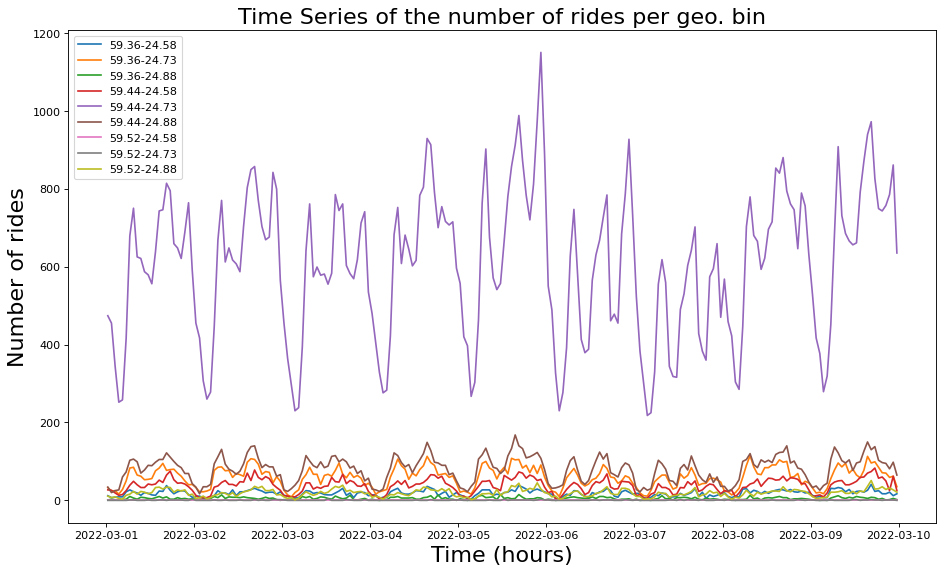

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 8), dpi=80)

for lat in latitude_list:
    for lng in longitude_list:

        Name = str(round(lat,2)) + '-' + str(round(lng,2))
        
        selected_time_series = []
        selected_time_series = time_series[(time_series.latitude == lat) & (time_series.longitude == lng)].copy()
        selected_time_series = selected_time_series[selected_time_series.time < '2022-03-10'].copy()
        #selected_time_series = selected_time_series[selected_time_series.time < '2022-03-03'].copy()

        mean_rides = selected_time_series.number_of_rides.mean()
        std_rides =  selected_time_series.number_of_rides.std()
        
        #plt.plot(selected_time_series.time, (selected_time_series.number_of_rides - mean_rides)/std_rides, label = Name)
        plt.plot(selected_time_series.time, selected_time_series.number_of_rides, label = Name)
        plt.legend()
        plt.xlabel("Time (hours)", fontsize=20)
        plt.ylabel("Number of rides", fontsize=20)
        plt.title("Time Series of the number of rides per geo. bin", fontsize=20)

In [ ]:
""" Each color represents a bin. The central bin (59.44-24.73) is evidently the most populated one, 
with a higher number of rides. This trend is also apparent in the accompanying animation, 
which shows that the majority of rides are concentrated in the central bin."""

### Simple Animation

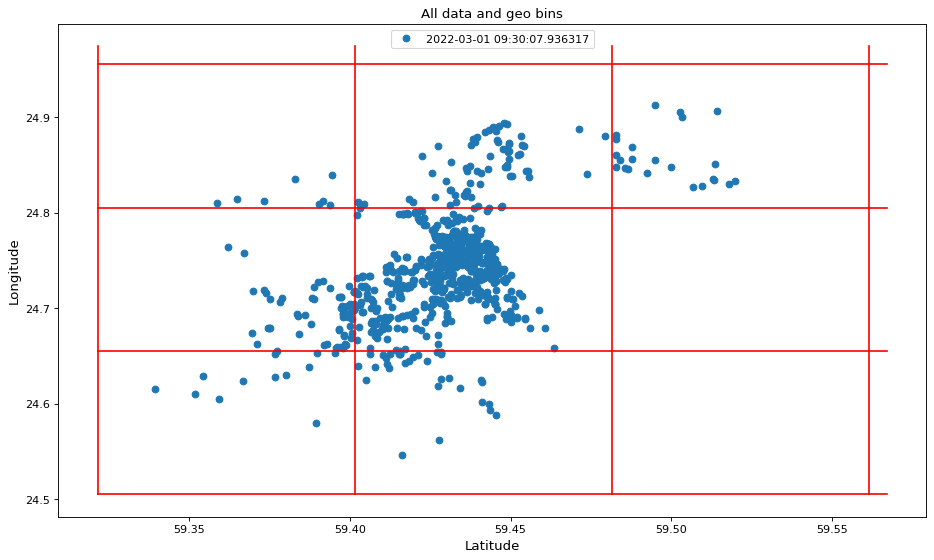

In [91]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np

for z in range(0, 10): #len(time_bins)-1):
        
    clear_output(wait=True)
    
    figure(figsize=(14, 8), dpi=80)

    df_time_section = []
    df_time_section = df[(df.start_time >= time_bins[z]) & (df.start_time < time_bins[z+1])]
   
    x = df_time_section.start_lat.values
    y = df_time_section.start_lng.values
    
    time = []
    time = (time_bins[z+1] - time_bins[z])/2 + time_bins[z] 
    
    plt.plot(x, y, 'o', label = time)

    for BIN in bin_lat:
        plt.plot([BIN, BIN], [min(df.start_lng.values), max(df.start_lng.values)], c='r')
    for BIN in bin_lng:
        plt.plot([min(df.start_lat.values), max(df.start_lat.values)], [BIN, BIN], c='r')
    
    plt.title('All data and geo bins', fontsize=12)
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel('Longitude', fontsize=12)
    plt.legend()
    
    plt.show()

In [ ]:
""" Furthermore, the bins exhibit a high level of correlation. 
Please refer to the standardized variables in the plot below, noting that the correlations between 
the central bin and the remaining bins are above 0.76. """

### Plot: Standardized Time Series 

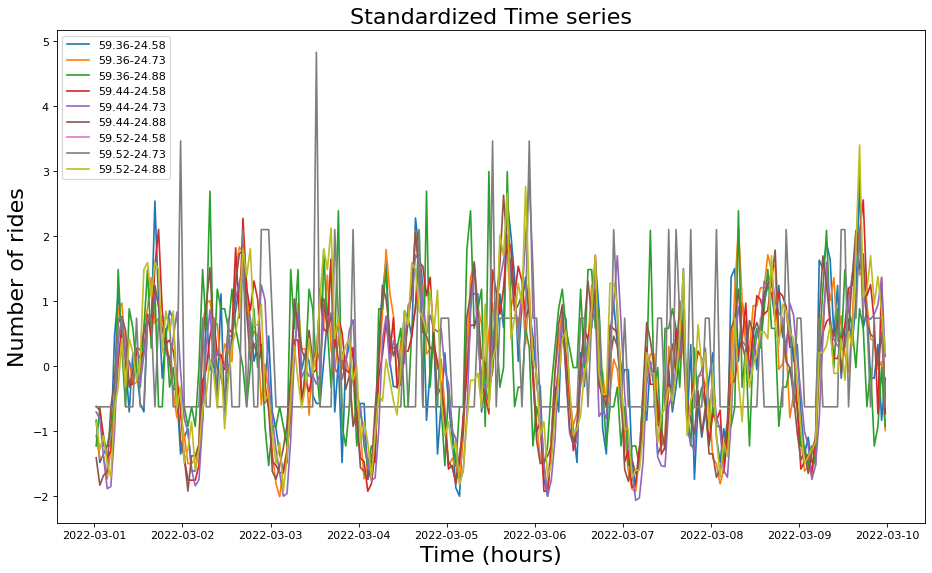

In [40]:
figure(figsize=(14, 8), dpi=80)

for lat in latitude_list:
    for lng in longitude_list:

        Name = str(round(lat,2)) + '-' + str(round(lng,2))
        
        selected_time_series = []
        selected_time_series = time_series[(time_series.latitude == lat) & (time_series.longitude == lng)].copy()
        selected_time_series = selected_time_series[selected_time_series.time < '2022-03-10'].copy()
        #selected_time_series = selected_time_series[selected_time_series.time < '2022-03-03'].copy()

        mean_rides = selected_time_series.number_of_rides.mean()
        std_rides =  selected_time_series.number_of_rides.std()
        
        plt.plot(selected_time_series.time, (selected_time_series.number_of_rides - mean_rides)/std_rides, label = Name)
        #plt.plot(selected_time_series.time, selected_time_series.number_of_rides, label = Name)
        plt.legend()
        plt.xlabel("Time (hours)", fontsize=20)
        plt.ylabel("Number of rides", fontsize=20)
        plt.title("Standardized Time series", fontsize =20)

### Correlation between the center bin and the other bins

In [11]:
### Time Series of the center bin

center_bin_lat = latitude_list[1] ### center bin coordinates
center_bin_lngt = longitude_list[1] ### center bin coordinates

time_series_center = []
time_series_center = time_series[(time_series.latitude == center_bin_lat) & 
                            (time_series.longitude == center_bin_lngt)][['time','number_of_rides']].copy()
time_series_center.set_index('time', inplace=True) 

### Correlation to other bins 

for i, lat in enumerate(latitude_list):
    for j, lng in enumerate(longitude_list):

            time_series_ij = []
            time_series_ij = time_series[(time_series.latitude == latitude_list[j]) & 
                                         (time_series.longitude == longitude_list[j])][['time','number_of_rides']].copy()
            time_series_ij.set_index('time', inplace=True) 

            print("Correlation between center bin and Bin i:", i ,"Bin j:", j, "Correlation: ", round(time_series_center.number_of_rides.corr(time_series_ij.number_of_rides),2))

Correlation between center bin and Bin i: 0 Bin j: 0 Correlation:  0.76
Correlation between center bin and Bin i: 0 Bin j: 1 Correlation:  1.0
Correlation between center bin and Bin i: 0 Bin j: 2 Correlation:  0.82
Correlation between center bin and Bin i: 1 Bin j: 0 Correlation:  0.76
Correlation between center bin and Bin i: 1 Bin j: 1 Correlation:  1.0
Correlation between center bin and Bin i: 1 Bin j: 2 Correlation:  0.82
Correlation between center bin and Bin i: 2 Bin j: 0 Correlation:  0.76
Correlation between center bin and Bin i: 2 Bin j: 1 Correlation:  1.0
Correlation between center bin and Bin i: 2 Bin j: 2 Correlation:  0.82


In [12]:
""" This implies that our modeling efforts can be concentrated on the central bin. A similar model should be also 
useful in case we want to extend the approach and forecast other bins."""

' This implies that our modeling efforts can be concentrated on the central bin. A similar model should be also \nuseful in case we want to extend the approach and forecast other bins.'

### Make Forecast only for the center bin / time series

Text(0.5, 1.0, 'Time Series of the central geo. bin')

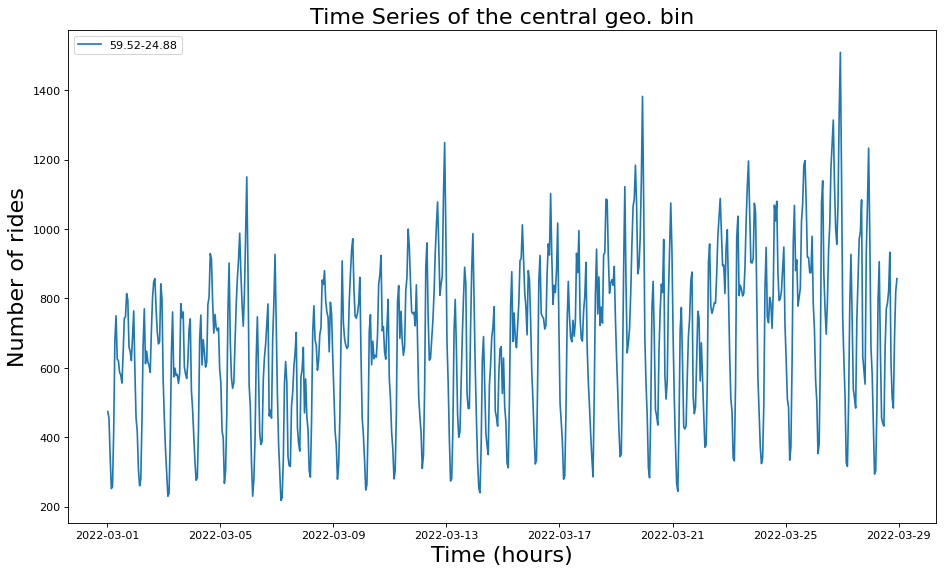

In [14]:
selected_time_series = []
selected_time_series = time_series[(time_series.latitude == center_bin_lat) & 
                                   (time_series.longitude == center_bin_lngt)].copy()
selected_time_series.set_index('time', inplace=True) 

figure(figsize=(14, 8), dpi=80)
plt.plot(selected_time_series.number_of_rides, label = Name)
plt.legend()
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Number of rides", fontsize=20)
plt.title("Time Series of the central geo. bin", fontsize=20)

### Exploring Time Series to account recurring patterns

In [ ]:
""" As illustrated in the figure above, the time series exhibits at least two apparent seasonalities 
or recurring patterns: a 24-hour daily pattern and a 7-day weekly pattern. This can be corroborated by analyzing 
the autocorrelation and partial autocorrelation functions."""

### Autocorrelation Plot to confirm daily seasonality

In [ ]:
""" For later use, we identify a Seasonal Period which is the highest autocorrelation coefficient (besides 0 and 1)
    As expected this period is 24 hours which is the number of hours in a day."""

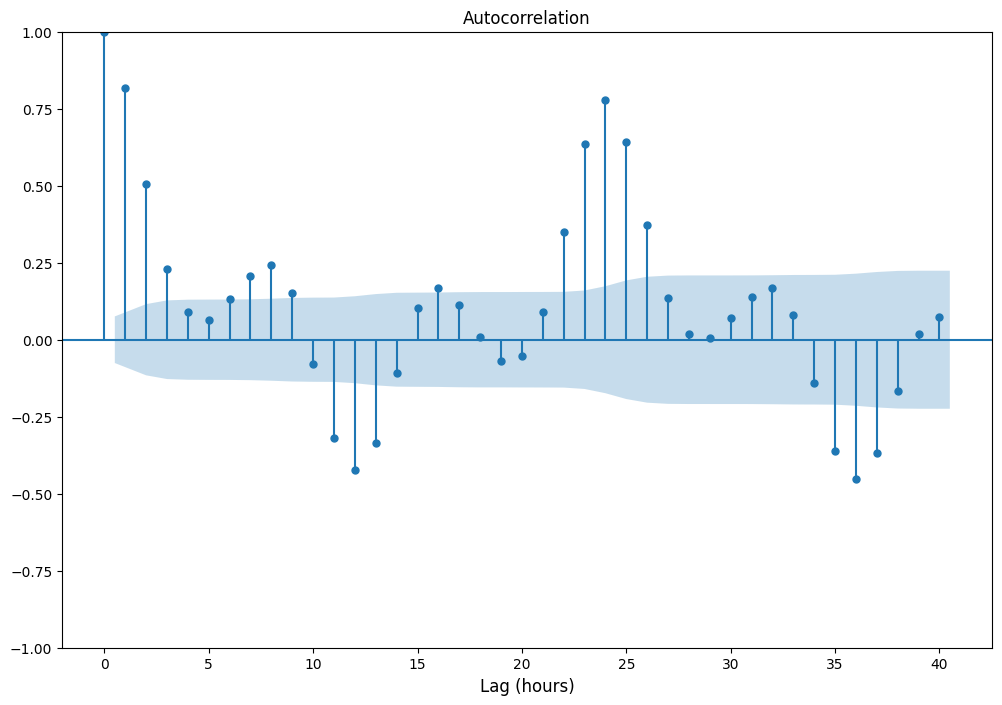

In [21]:
import statsmodels.api as sm

f_acf = sm.graphics.tsa.plot_acf(selected_time_series['number_of_rides'], lags=40)

f_acf.set_figheight(8)
f_acf.set_figwidth(12)
plt.xlabel("Lag (hours)", fontsize=12)
plt.show()

### Partial Autocorrelation shows the presence of "memory" in the daily seasonality wich extends to a week

In [ ]:
""" The weekly pattern or seasonality can be seen in the lag 168 hours which corresponds to 7 days = 7*24 = 168."""

Text(0.5, 0, 'Lag (hours)')

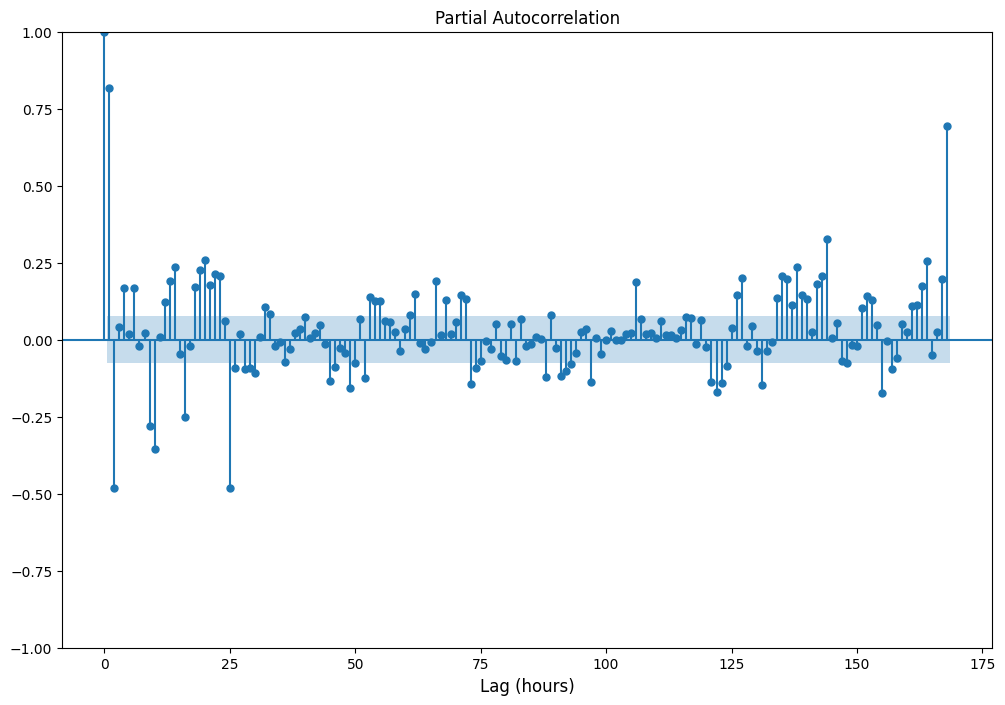

In [20]:
f_pacf = sm.graphics.tsa.plot_pacf(selected_time_series['number_of_rides'], lags=168, method='ols')

f_pacf.set_figheight(8)
f_pacf.set_figwidth(12)
plt.xlabel("Lag (hours)", fontsize=12)

### Forecast with SarimaX



In [ ]:
""" I employ a SarimaX model due to its simplicity, speed, cost-effectiveness, 
and the high degree of parameter flexibility it offers for accurately representing complex time series patterns. 
Based on my own experience, it serves as an effective baseline model. 

To determine the parameters, I leverage information from the autocorrelation and partial autocorrelation functions.

I divide the data into a training set for parameter estimation and a validation set for assessing forecast viability.

It is not necessary to define a test to train this type of parametrical model. 
On the contrary it will be necessary to define a test set if we want to train typical 
non-parametric machine learning models, such as Random Forest, XGBoost, and Neural Networks.  """

In [22]:
Percentage_of_data_for_training = 70 ### 70% of the data for training the algo, leaves 30% for validation.

n = selected_time_series.shape[0]
cut = round(Percentage_of_data_for_training*n/100) 
print(n, "cut: ", cut)

Training_Datum = selected_time_series.index[cut] 
print(Training_Datum)

671 cut:  470
2022-03-20 14:30:07.936317


In [23]:
### Training Data

model_train = []
model_train = selected_time_series[(selected_time_series.index <= Training_Datum)]['number_of_rides']

### Validation Data

model_validation = []
model_validation = selected_time_series[(selected_time_series.index > Training_Datum)]['number_of_rides']

print("Training up to: ", model_train.index.max(), "Validation from: ", model_validation.index.min())
print("Length Training Set: ", model_train.shape[0], "Length Test Set: ", model_validation.shape[0])

Training up to:  2022-03-20 14:30:07.936317 Validation from:  2022-03-20 15:30:07.936317
Length Training Set:  471 Length Test Set:  200


### SarimaX Modell

In [24]:
import statsmodels.api as sm

### Parameters

AR = 0
MA = 0
Diff = 0
TREND = None #'c' #None #'ct' #None

ARs = 7 ### Weekly "memory". See Partial autocorrelation.
MAs = 0
S = 24 ### Seasonal period, indicating a daily seasonality. 
Diffs = 0

### Model Tranining

mod = sm.tsa.statespace.SARIMAX(model_train,
                                order = (AR,Diff,MA),
                                seasonal_order = (ARs,Diffs,MAs,S),
                                trend= TREND,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

C:\Users\celes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\celes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [25]:
### Model Prediction

START_PRED = selected_time_series.index[cut+1]
END_PRED = '2022-04-01'

prediction = []
prediction = results.predict(start=START_PRED, end= END_PRED)
                
print("END_PRED: ", END_PRED)

df_prediction = []
df_prediction = prediction.to_frame()

END_PRED:  2022-04-01


(19062.604258522188, 19083.0)

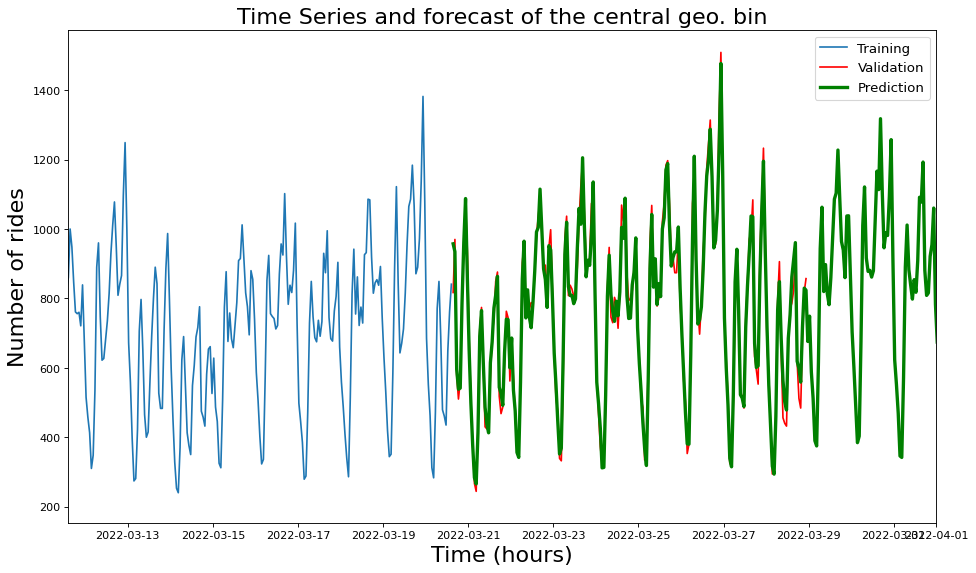

In [26]:
import datetime

figure(figsize=(14, 8), dpi=80)

plt.plot(model_train, label = 'Training')
plt.plot(model_validation, label = 'Validation', color='r')
plt.plot(df_prediction, label = 'Prediction', color='g', linewidth=3)
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Number of rides", fontsize=20)
plt.title("Time Series and forecast of the central geo. bin", fontsize=20)
plt.legend(fontsize=12)

ax = plt.gca()
ax.set_xlim([selected_time_series.index[cut-24*9], datetime.datetime.strptime(END_PRED, "%Y-%m-%d").date()])

### Model Evaluation with Mean Square Error and Root MSE

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(model_validation, df_prediction[df_prediction.index<=model_validation.index.max()])

rmse = np.sqrt(mse)

print("mse: ", mse, "rmse: ", rmse)

mse:  1624.7195115598174 rmse:  40.30780956042907


In [ ]:
""" The close alignment between predicted and unseen actual values strongly suggests that the data is synthetic, 
exhibiting two main seasonal patterns - a daily and weekly seasonality. In practical situations, 
depending on the required level of accuracy, a rolling forecast will be conducted along with supporting results 
through forward cross-validation, for instance, to determine realistic confidence intervals.

Furthermore, it would be intriguing to explore a Vector Autoregressive (VAR) model to ascertain 
whether comparable levels of accuracy can be attained by considering the contribution 
of the time series in the remaining geographical bins. his approach would enable us to generate forecasts 
for all geographical bins simultaneously as well. """

### Specific Questions

In [ ]:
"""
- Your take on how the impact of the model should be evaluated in real-world interactions with our user base. 

The model could be tested in an A/B test, where a percentage of cars use a version of the application 
with an integrated forecast, and the performance (number of rides per day or week) is compared against 
the same percentage of cars without the forecast tool. A comparison between both distributions of rides 
can be utilized to evaluate the impact of the model in realistic scenarios. 

- Describe how you would design and deploy such a model

I would set up a Git repository to facilitate model versioning, collaboration and ensure the documentation 
remains current. 
If databases are accessible programmatically, I would strive to automate the entire process, including data ingestion, 
processing, model training, and forecasting. 
I would store the forecasts in a database so that Bolt's application can retrieve and display them for the drivers.

- Describe how to communicate model recommendations to drivers

I would color-code the map that the driver sees with the predicted number of rides 
(high – red, medium – yellow, low – blue). The driver can decide at any time which area he wants to go to.   

- Please describe what additional data would you consider useful and cite the main references used in your solution, if any.

I will investigate whether special events (such as concerts, live shows, planned road constructions, etc.) 
are associated with higher or lower than anticipated ride volumes in specific time and locations. 
If a correlation exists, I will utilize this insights to challenge the actual forecast model.    

"""

## Reshape DataFrame for VAR Modelling

In [73]:
new_time_series = []
BIN = 0
for lat in time_series.latitude.unique():
    for long in time_series.longitude.unique():
        rides_bin = []
        rides_bin = time_series[(time_series.latitude == lat) & 
                                     (time_series.longitude == long)][['time','number_of_rides']]
        
        rides_bin.rename(columns={"number_of_rides": BIN}, inplace=True)
        rides_bin.set_index('time', inplace=True)
        
        BIN+=1
        
        if len(new_time_series)==0:
            new_time_series = rides_bin.copy()
        else:
            new_time_series = new_time_series.join(rides_bin) 
                      
print(new_time_series.shape)

new_time_series.head()

(671, 9)


,0,1,2,3,4,5,6,7,8
time,,,,,,,,,
2022-03-01 00:30:07.936317,12,33,1,27,474,34,0,0,11
2022-03-01 01:30:07.936317,7,24,3,26,455,20,0,0,7
2022-03-01 02:30:07.936317,8,25,1,19,344,25,0,0,9
2022-03-01 03:30:07.936317,9,16,1,13,252,27,0,0,5
2022-03-01 04:30:07.936317,9,28,2,15,258,60,0,0,3


### Filter geo. bins with not enough rides

In [74]:
### keep only bins that have enough rides

column_keep = []
for column in new_time_series.columns:
    if new_time_series[column].mean() > 40:
         column_keep.append(column)
print("I am keeping these bins: ", column_keep)
new_time_series = new_time_series[column_keep]
new_time_series.head(2)

I am keeping these bins:  [1, 3, 4, 5]


,1,3,4,5
time,,,,
2022-03-01 00:30:07.936317,33,27,474,34
2022-03-01 01:30:07.936317,24,26,455,20


### Exogenous Variables for daily and weekly patterns 

In [75]:
new_time_series['weekday'] = np.nan
new_time_series['hour'] = np.nan

for index in new_time_series.index.unique():
    new_time_series.loc[index,"weekday"] = int(index.weekday())
    new_time_series.loc[index,"hour"] = int(index.hour)

new_time_series.head(2)

,1,3,4,5,weekday,hour
time,,,,,,
2022-03-01 00:30:07.936317,33,27,474,34,1.0,0.0
2022-03-01 01:30:07.936317,24,26,455,20,1.0,1.0


In [82]:
new_time_series.shape[1]

6

In [76]:
Percentage_of_data_for_training = 70 ### 70% of the data for training the algo, leaves 30% for validation.

n = new_time_series.shape[0]
cut = round(Percentage_of_data_for_training*n/100) 
print(n, "cut: ", cut)

Training_Datum = new_time_series.index[cut] 
print(Training_Datum)

671 cut:  470
2022-03-20 14:30:07.936317


In [77]:
### Training Data

model_train = []
model_train = new_time_series[(new_time_series.index <= Training_Datum)]

### Validation Data

model_validation = []
model_validation = new_time_series[(new_time_series.index > Training_Datum)]

print("Training up to: ", model_train.index.max(), "Validation from: ", model_validation.index.min())
print("Length Training Set: ", model_train.shape[0], "Length Test Set: ", model_validation.shape[0])

Training up to:  2022-03-20 14:30:07.936317 Validation from:  2022-03-20 15:30:07.936317
Length Training Set:  471 Length Test Set:  200


In [78]:
#from statsmodels.tsa.api import VAR

### Define Train & Validation Sets 

#model = VAR(endog= model_train[model_train.columns[0:6]],
#            exog = model_train[model_train.columns[6:8]], ### weekly and daily patterns
#            freq='H') ### include exogenous variables for seasonalities.

In [84]:
model_train[model_train.columns[new_time_series.shape[1]-2:new_time_series.shape[1]]]

,weekday,hour
time,,
2022-03-01 00:30:07.936317,1.0,0.0
2022-03-01 01:30:07.936317,1.0,1.0
2022-03-01 02:30:07.936317,1.0,2.0
2022-03-01 03:30:07.936317,1.0,3.0
2022-03-01 04:30:07.936317,1.0,4.0
...,...,...
2022-03-20 10:30:07.936317,6.0,10.0
2022-03-20 11:30:07.936317,6.0,11.0
2022-03-20 12:30:07.936317,6.0,12.0


In [102]:
from statsmodels.tsa.statespace.varmax import VARMAX

#model_train = model_train.astype(np.float32)

model = VARMAX(endog = model_train[model_train.columns[0:new_time_series.shape[1]-2]],
               exog =  model_train[model_train.columns[new_time_series.shape[1]-2:new_time_series.shape[1]]],
               freq = 'H', 
               order=(1,0),
              low_memory=True) 
               #seasonal_order=(0, 0, 0, 24),
                #mle_regression = False,
                #filter_concentrated = False)

model_fit = model.fit()

C:\Users\celes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [106]:
#df_forecast = model_fit.predict(new_time_series.shape[0])

df_forecast = model_fit.simulate(new_time_series.shape[0]), 
                                 exog = model_validation[model_validation.columns[new_time_series.shape[1]-2:new_time_series.shape[1]])
df_forecast.tail()

#df_forecast=pd.DataFrame(data=pred, index=model_validation.index, columns = column_keep)
#df_forecast.head(2)

IndentationError: unexpected indent (1046992508.py, line 4)

In [ ]:
import datetime

for i in range(0, df_forecast.shape[1]):

    figure(figsize=(14, 8), dpi=80)

    plt.plot(model_train[model_train.columns[i]], label = 'Training',color ='k')
    plt.plot(model_validation[model_validation.columns[i]], label = 'Validation', color='r')
    plt.plot(df_forecast[df_forecast.columns[i]], label = 'Prediction', color='g', linewidth=3)
    plt.xlabel("Time (hours)", fontsize=20)
    plt.ylabel("Number of rides", fontsize=20)
    plt.title("Time Series and forecast of the central geo. bin", fontsize=20)
    plt.legend(fontsize=12)
    
    ax = plt.gca()
    ax.set_xlim([new_time_series.index[cut-24*2], model_validation.index[-1]])

In [33]:
results = model.fit(24)
lagged_Values = model_train[model_train.columns[0:6]].values

pred = []
pred = results.forecast(y=lagged_Values, 
                        exog_future=model_validation[model_validation.columns[6:8]], 
                        steps = model_validation.shape[0])

df_forecast=pd.DataFrame(data=pred, index=model_validation.index, columns = column_keep)
df_forecast.head(2)

ValueError: shape mismatch: value array of shape (0,) could not be broadcast to indexing result of shape (21,)